# Postprocessing: data quality check using the analysis

### Reading data as before

In [1]:
import divand
using PyPlot

In [2]:
varname = "Salinity"
filename = "WOD-Salinity-Provencal.nc"


if !isfile(filename)    
    download("https://b2drop.eudat.eu/s/UsF3RyU3xB1UM2o/download",filename)
end

value,lon,lat,depth,obstime,ids = divand.loadobs(Float64,filename,"Salinity");

(Any) in module Vocab at C:\Users\jmbeckers\.julia\v0.6\divand\src\Vocab.jl:22 overwritten at C:\Users\jmbeckers\.julia\v0.6\divand\src\Vocab.jl:46.


### Topography and grid definition

See other notebook for explanation. Here just code replicated to get topography defining the mask

In [3]:
dx = dy = 0.125/2.
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

mask,(pm,pn),(xi,yi) = divand.divand_rectdom(lonr,latr)

bathname = "gebco_30sec_4.nc"




if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download",bathname)
else
    info("Bathymetry file already downloaded")
end


bx,by,b = divand.load_bath(bathname,true,lonr,latr)



mask = falses(size(b,1),size(b,2))


    for j = 1:size(b,2)
        for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
        end
    end


INFO: Bathymetry file already downloaded


### Data selection for example

Cross validation, error calculations etc. assume independant data. Hence do not take high-resolution vertical profiles with all data but restrict yourself to specific small depth range. Here August data at surface:

In [4]:
sel = (depth .< 1) .& (Dates.month.(obstime) .== 8)

value = value[sel]
lon = lon[sel]
lat = lat[sel]
depth = depth[sel]
obstime = obstime[sel]
ids = ids[sel];
@show (size(value))
divand.checkobs((lon,lat,depth,obstime),value,ids)

size(value) = (1956,)
              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (1910-08-09T00:00:00, 2014-08-28T19:36:00)
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


### Analysis

Analysis parameters have been calibrated in the other notebook example. 

Analysis fi using mean data as background. Structure s is stored for later use

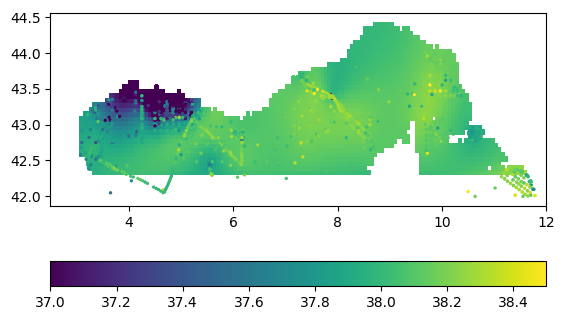

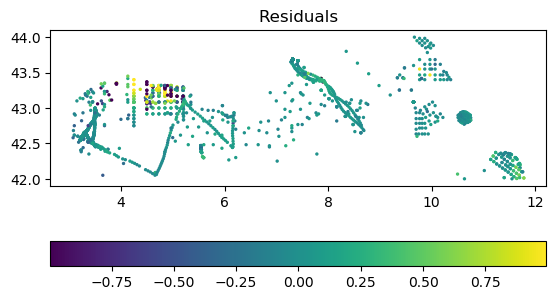

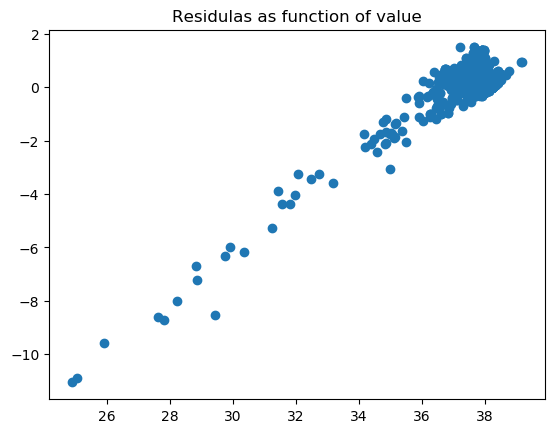

In [5]:
figure()

len=0.5
epsilon2=5
fi,s = divand.divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value-mean(value),len,epsilon2);

pcolor(xi,yi,fi+mean(value),vmin=37,vmax=38.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
dataresiduals=divand.divand_residualobs(s,fi)
scatter(lon,lat,s=2,c=value,vmin=37,vmax=38.5)




rscale=sqrt(var(value))

figure()
scatter(lon,lat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Residuals")


figure()
scatter(value,dataresiduals)
title("Residulas as function of value");


# Data quality check

As for cross validation, in theory take out data and measure difference between these data points not used and the analysis. Can be done without actually taking out the points. Three methods are implemented 
# Define method used
    

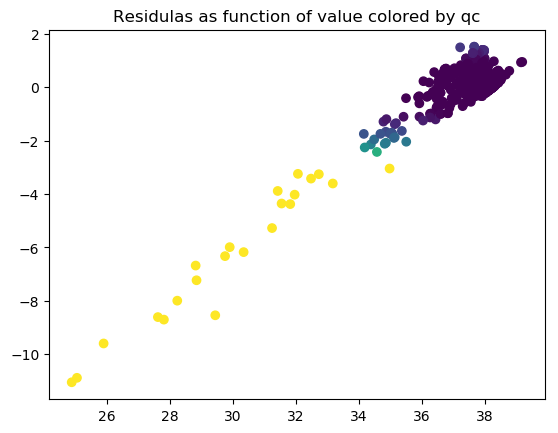

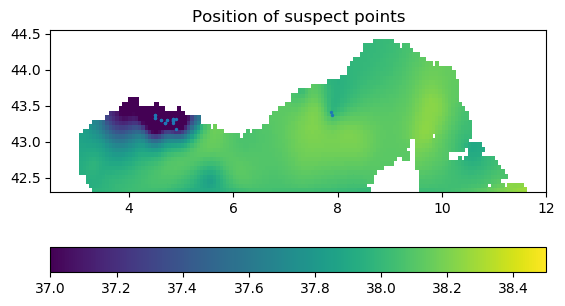

PyObject Text(0.5,1,u'Position of suspect points')

In [16]:
qcval=divand.divand_qc(fi,s,1)

# Find suspect points

sp=find(x-> x.>10,qcval)


# Or sort the indicator
suspectindexes=sortperm(qcval,rev=true)


figure()
scatter(value,dataresiduals,c=qcval,vmin=1,vmax=10)
title("Residulas as function of value colored by qc");

figure()



pcolor(xi,yi,fi+mean(value),vmin=37,vmax=38.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

scatter(lon[sp],lat[sp],s=2)
title("Position of suspect points")

# More information

In [7]:
?divand.divand_qc

Compute a variational analysis of arbitrarily located observations to calculate data quality estimators

qcvalues,indexes = divand_qc(fi,s);

If the optional argument it describes the method to be used:

method=1 as for standard cross validation method=3 as for GCV method=4 with CV estimator to be used outside the routine

use sortperm to find most suspect values


# Exercise

* Redo for different data.
* Possibly force the cross-validation method (use ?divand_cv)
* Once opimized, try to redo optimization with starting point being the first estimate+
* Change level for qc parameter used for flagging
* Create non-uniform weights for data using the quality check parameter. Then redo the analysis and possibly the whole chain from analysis, calibration

# Data quality check using analysis-data misfits is usefull but should not replace PREPROCESSING quality checks and proper quality flag exploitation.